In [ ]:
!nvidia-smi

Tue Oct 13 19:06:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensor
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/content/drive/My Drive/'
train_df = pd.read_csv(DIR_INPUT + "train.csv")
DIR_TRAIN = f'{DIR_INPUT}/jet-blue_planes'
train_df=train_df.rename(columns={"index": "image"})

In [ ]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['box'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['box'], inplace=True)
train_df['x'] = train_df['x'].astype(np.int32)
train_df['y'] = train_df['y'].astype(np.int32)
train_df['w'] = train_df['w'].astype(np.int32)
train_df['h'] = train_df['h'].astype(np.int32)

In [ ]:
image_ids = train_df['image'].unique()
train_ids = image_ids[:220]
valid_ids = image_ids[220:]
valid_df = train_df[train_df['image'].isin(valid_ids)]
train_df = train_df[train_df['image'].isin(train_ids)]

In [ ]:
train_df

,image,class,x,y,w,h
0,resized_2part13.jpg,jet_blue,208,357,339,422
1,resized_2part13.jpg,jet_blue,45,298,111,334
2,resized_2part48.jpg,jet_blue,65,334,177,414
3,resized_2part48.jpg,jet_blue,40,132,99,177
4,resized_2part48.jpg,jet_blue,216,168,319,233
...,...,...,...,...,...,...
316,resized_2part15.jpg,jet_blue,105,142,146,183
317,resized_2part15.jpg,jet_blue,388,278,480,350
318,resized_2part125.jpg,jet_blue,92,208,165,252
319,resized70.jpg,jet_blue,53,180,101,205


In [ ]:
class PlaneDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image'] == image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        boxes = records[['x', 'y', 'w', 'h']].values
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
class TestDataset(Dataset):
    def __init__(self, image_dir, transforms=None):
        super().__init__()

        self.image_list = os.listdir(image_dir)
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_list[index]
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image

    def __len__(self) -> int:
        return len(self.image_list)

In [ ]:
def get_train_transform():
    return A.Compose([
        ToTensor()
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensor()
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = PlaneDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = PlaneDataset(valid_df, DIR_TRAIN, get_valid_transform())

indices = torch.randperm(len(train_dataset)).tolist()
batch=5

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=batch,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


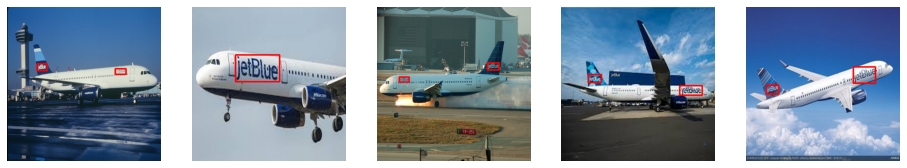

In [ ]:
images, targets = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
fig, ax = plt.subplots(1, batch, figsize=(16, 10))
for i in range(len(images)):
  boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
  sample = images[i].permute(1,2,0).cpu().numpy()
  for box in boxes:
      cv2.rectangle(sample,
                    (box[0], box[1]),
                    (box[2], box[3]),
                    (220, 0, 0), 3)
      
  ax[i].set_axis_off()
  ax[i].imshow(sample)

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2 
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

def train_model(model_conv,train_loader, valid_loader, optimizer, criterion, num_epochs, scheduler):
  loss_hist = criterion
  for epoch in range(num_epochs):
      loss_hist.reset()
      print(f"Epoch #{epoch} starts")
      for images, targets in train_loader:
          
          images = list(image.to(device)for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
          loss_dict = model_conv(images, targets)

          losses = sum(loss for loss in loss_dict.values())
          loss_value = losses.item()
          loss_hist.send(loss_value)

          optimizer.zero_grad()
          losses.backward()
          optimizer.step()
      val_loss = []
      for images, targets  in valid_loader:
          images = list(image.to(device)for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
          loss_dict = model_conv(images, targets)
          losses = sum(loss for loss in loss_dict.values())
          loss_value = losses.item()
          val_loss.append(loss_value)

      scheduler.step()
      torch.save(model.state_dict(), '/content/drive/My Drive/jet_blue_weights/model_final_fasterrcnn_resnet50_weights.pt')

      print(f"Epoch #{epoch} Train_loss: {loss_hist.value}, Val_loss: {loss_value}") 

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
n_epochs = 40
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,35], gamma=0.1)
train_model(model,train_data_loader, valid_data_loader, optimizer, Averager(), n_epochs, scheduler)

Epoch #0 starts


/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch #0 Train_loss: 0.3326035477221012, Val_loss: 0.1424160897731781
Epoch #1 starts
Epoch #1 Train_loss: 0.1568137105893005, Val_loss: 0.08898696303367615
Epoch #2 starts
Epoch #2 Train_loss: 0.10018395276909525, Val_loss: 0.1721748262643814
Epoch #3 starts
Epoch #3 Train_loss: 0.0849253728308461, Val_loss: 0.150480717420578
Epoch #4 starts
Epoch #4 Train_loss: 0.06894333152608438, Val_loss: 0.21881583333015442
Epoch #5 starts
Epoch #5 Train_loss: 0.06313072140751914, Val_loss: 0.10084837675094604
Epoch #6 starts
Epoch #6 Train_loss: 0.05762040966444395, Val_loss: 0.07195338606834412
Epoch #7 starts
Epoch #7 Train_loss: 0.053937132343311205, Val_loss: 0.10256841033697128
Epoch #8 starts
Epoch #8 Train_loss: 0.047318054447797214, Val_loss: 0.18151134252548218
Epoch #9 starts
Epoch #9 Train_loss: 0.04252370019358667, Val_loss: 0.23623888194561005
Epoch #10 starts
Epoch #10 Train_loss: 0.040590148673138836, Val_loss: 0.15412381291389465
Epoch #11 starts
Epoch #11 Train_loss: 0.038680603